In [ ]:
from pytube import YouTube
%matplotlib inline
import cv2
import os
import numpy as np
import mediapipe as mp
import matplotlib.pyplot as plt

def download_youtube_video(youtube_url, save_path="."):
    yt = YouTube(youtube_url)
    ys = yt.streams.get_highest_resolution()
    ys.download(save_path)
    return ys.default_filename

# 유튜브 URL로부터 영상 다운로드
video_filename = download_youtube_video('https://www.youtube.com/watch?v=6-E6qrs99-k')




In [ ]:

def capture_frames(video_path, frame_interval, prefix, output_dir):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print("Error: Could not open video.")
        return []

    saved_images = [os.path.join(output_dir, f"{prefix}_{i}.png") for i in range(0, int(cap.get(cv2.CAP_PROP_FRAME_COUNT)), frame_interval) if cap.read()[0]]
    cap.release()
    return saved_images

def capture_specific_frames(video_path, frame_list, prefix, output_dir):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print("Error: Could not open video.")
        return []

    saved_images = []
    for i in range(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))):
        ret, frame = cap.read()
        if not ret:
            break
        if i in frame_list:
            img_path = os.path.join(output_dir, f"{prefix}_{i}.png")
            cv2.imwrite(img_path, frame)
            saved_images.append(img_path)

    cap.release()
    return saved_images

def preprocess_video(video_path):
    cap = cv2.VideoCapture(video_path)

    fps = cap.get(cv2.CAP_PROP_FPS)

    frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(f'pr_{video_path}', fourcc, fps, (frame_width, frame_height))

    frame_count = 0

    while True:
        ret, frame = cap.read()

        if not ret:
            break

        frame_count += 1
        cv2.putText(frame, f"Frame: {frame_count}", (frame_width - 350, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2, cv2.LINE_AA)

        out.write(frame)

    cap.release()
    out.release()
    
def save_frames(video_path, frame_indices):
    cap = cv2.VideoCapture(video_path)

    frame_count = 0

    frames = []

    while True:
        ret, frame = cap.read()
        if not ret:
            break
        
        frame_count += 1

        if frame_count in frame_indices:
            frames.append(frame)

    cap.release()

    for i, frame in enumerate(frames):
        print(f"Saving frame {i}")
        cv2.imwrite(f"frame_{i}.png", frame)

conso_list = [80, 170, 275, 380, 470, 560, 650, 730, 820, 920, 1020, 1120, 1200, 1290]

save_frames("consonant korean.mp4", conso_list)
# preprocess_video("consonant korean.mp4")

In [106]:
import os
import csv
import cv2
import numpy as np
import mediapipe as mp
import matplotlib.pyplot as plt

# Mediapipe utilities
mp_hands = mp.solutions.hands
hands = mp_hands.Hands()
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles

def create_directory_if_not_exists(directory):
    """Ensure the directory exists."""
    if not os.path.exists(directory):
        os.makedirs(directory)

def normalize_landmarks(landmarks):
    """Normalize landmarks to range [0, 1]."""
    normalized = np.array([[landmark.x, landmark.y, landmark.z] for landmark in landmarks.landmark])
    normalized -= np.min(normalized, axis=0)
    normalized /= np.max(normalized, axis=0)
    return normalized

def draw_bounding_box(frame, normalized_landmarks):
    """Draw bounding box around normalized hand landmarks."""
    x_min, y_min, _ = np.min(normalized_landmarks, axis=0)
    x_max, y_max, _ = np.max(normalized_landmarks, axis=0)
    x_range = x_max - x_min
    y_range = y_max - y_min
    x_min -= x_range
    y_min -= y_range
    x_max += x_range
    y_max += y_range
    x_min, y_min = max(0, x_min), max(0, y_min)
    x_max, y_max = min(1, x_max), min(1, y_max)
    cv2.rectangle(frame, 
                  (int(x_min * frame.shape[1]), int(y_min * frame.shape[0])), 
                  (int(x_max * frame.shape[1]), int(y_max * frame.shape[0])), 
                  (0, 255, 0), 2
    )

def save_landmarks_to_csv(landmarks, csv_path, label):
    """Save hand landmarks to CSV file."""
    normalized_landmarks = normalize_landmarks(landmarks)
    with open(csv_path, mode='w', newline='') as csv_file:
        writer = csv.writer(csv_file)
        writer.writerow(['label', 'x', 'y', 'z'])
        for landmark in normalized_landmarks:
            writer.writerow([label, landmark[0], landmark[1], landmark[2]])

def process_image_data(image_path, output_dir):
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    label = os.path.splitext(os.path.basename(image_path))[0]
    
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    csv_dir = os.path.join(output_dir, 'csv')
    if not os.path.exists(csv_dir):
        os.makedirs(csv_dir)
    
    results = hands.process(image_rgb)

    if results.multi_hand_landmarks:
        for i, hand_landmarks in enumerate(results.multi_hand_landmarks):
            mp_drawing.draw_landmarks(
                image=image_rgb,
                landmark_list=hand_landmarks,
                connections=mp_hands.HAND_CONNECTIONS,
                landmark_drawing_spec=mp_drawing_styles.get_default_hand_landmarks_style(),
                connection_drawing_spec=mp_drawing_styles.get_default_hand_connections_style()
            )

            csv_filename = f"{label}.csv"
            csv_path = os.path.join(csv_dir, csv_filename)
            save_landmarks_to_csv(hand_landmarks, csv_path, label)

            draw_bounding_box(image_rgb, normalize_landmarks(hand_landmarks))
    
    image_path = os.path.join(output_dir, f"{label}.png")
    cv2.imwrite(image_path, cv2.cvtColor(image_rgb, cv2.COLOR_RGB2BGR))

    plt.imshow(image_rgb)
    plt.show()


def plot_csv_landmarks(csv_dir):
    """Plot hand landmarks from CSV files in directory with subplots for each label."""
    fig = plt.figure(figsize=(12, 12))
    labels = sorted(set([os.path.splitext(filename)[0] for filename in os.listdir(csv_dir) if filename.endswith(".csv")]))
    print(labels)
    num_plots = len(labels)
    rows = int(np.sqrt(num_plots))
    cols = int(np.ceil(num_plots / rows))
    plot_num = 1

    for label in labels:
        ax = fig.add_subplot(rows, cols, plot_num, projection='3d')
        ax.set_title(label)
        plot_num += 1

        csv_path = os.path.join(csv_dir, f"{label}.csv")
        with open(csv_path, mode='r') as csv_file:
            reader = csv.reader(csv_file)
            next(reader)  # Skip header row
            x, y, z = zip(*[(float(row[1]), float(row[2]), float(row[3])) for row in reader])

            for connection in mp_hands.HAND_CONNECTIONS:
                x_pair = [x[connection[0]], x[connection[1]]]
                y_pair = [y[connection[0]], y[connection[1]]]
                z_pair = [z[connection[0]], z[connection[1]]]
                ax.plot(x_pair, y_pair, z_pair, color='b')

            ax.scatter(x, y, z, s=10, c='r')

            ax.set_xlabel('X')
            ax.set_ylabel('Y')
            ax.set_zlabel('Z')
            ax.view_init(elev=45., azim=-45.)

    plt.tight_layout()
    plt.show()


def Landmark(input_dir, output_dir):
    """Process images in a directory and save results."""
    for filename in os.listdir(input_dir):
        if filename.endswith((".jpg", ".jpeg", ".png")):
            image_path = os.path.join(input_dir, filename)
            process_image_data(image_path, output_dir)

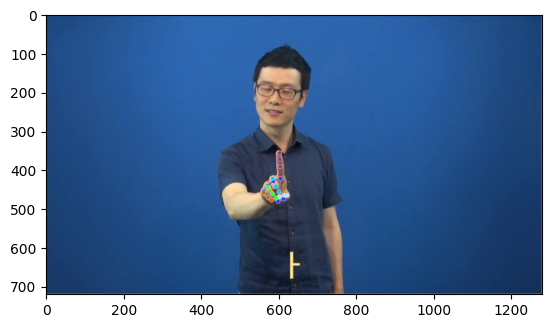

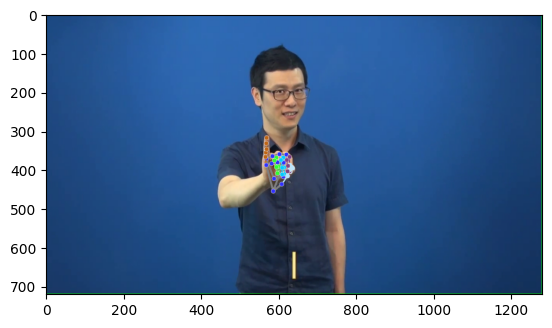

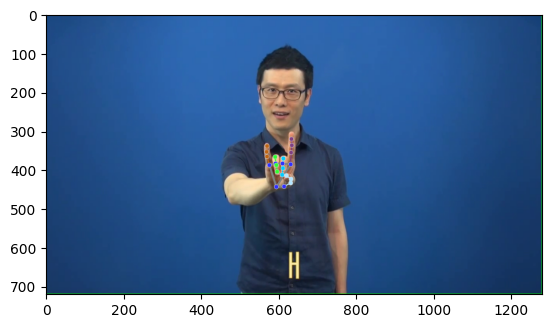

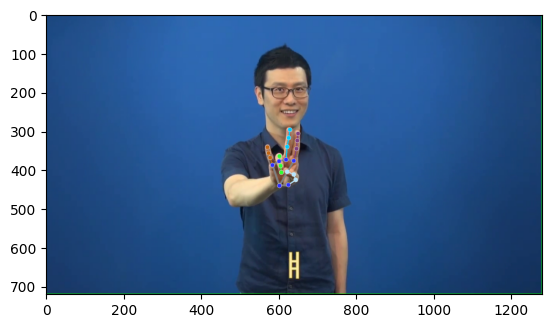

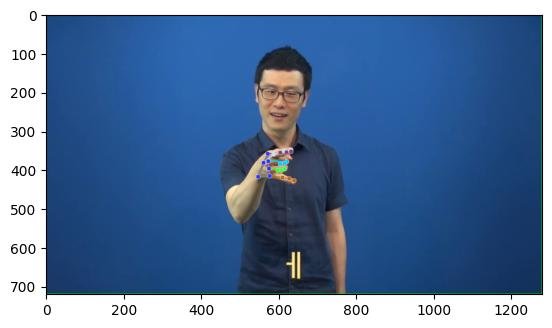

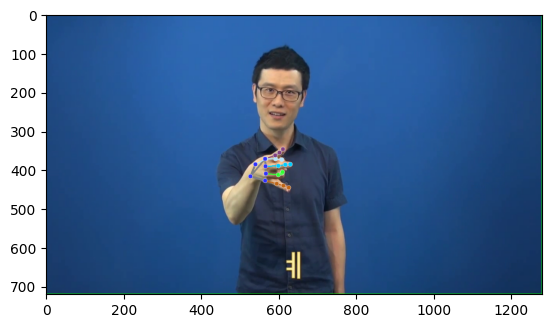

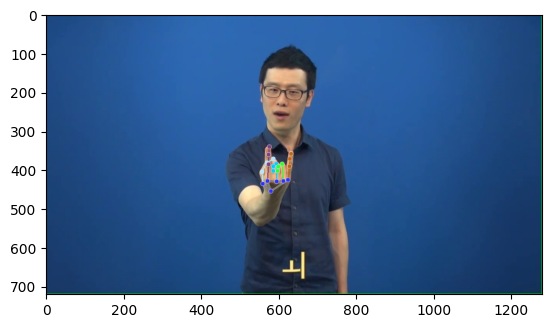

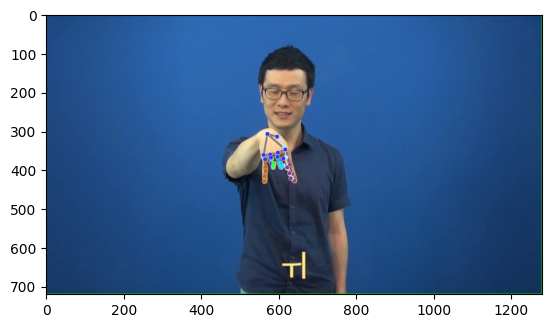

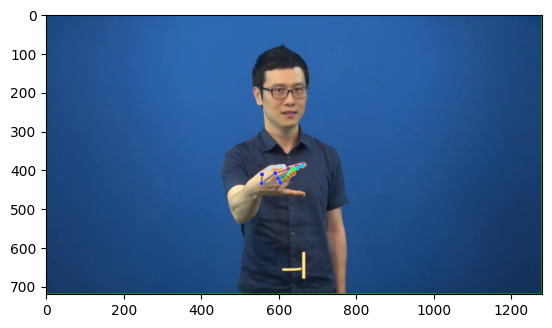

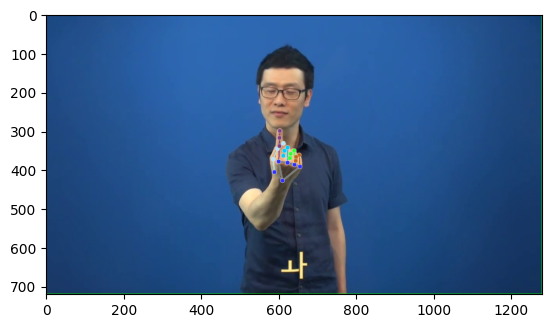

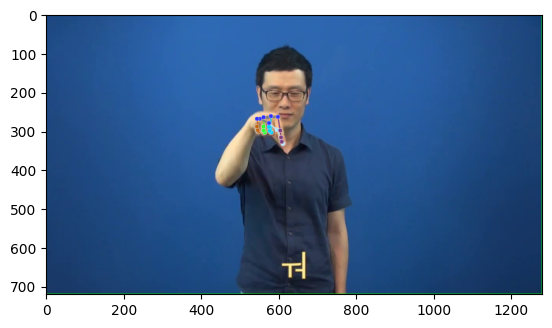

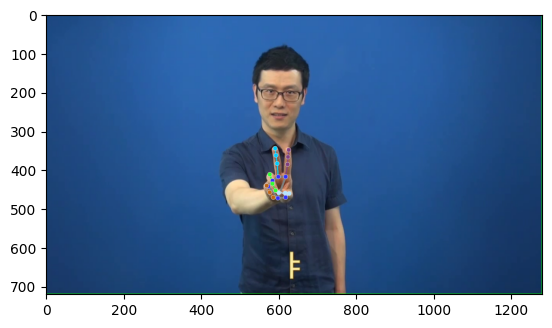

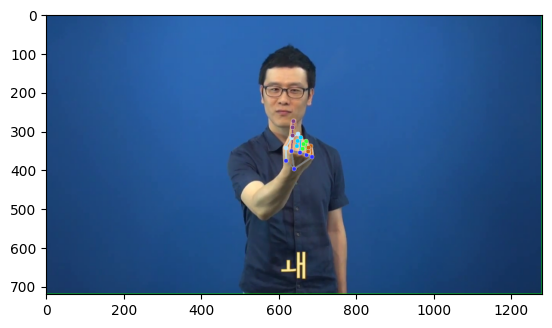

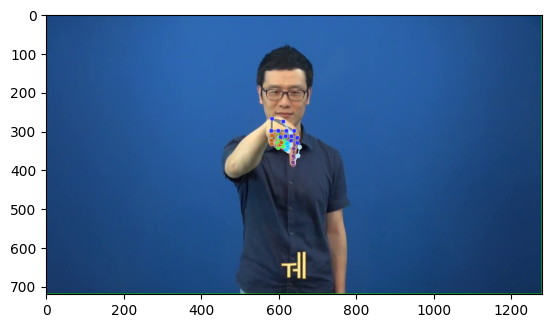

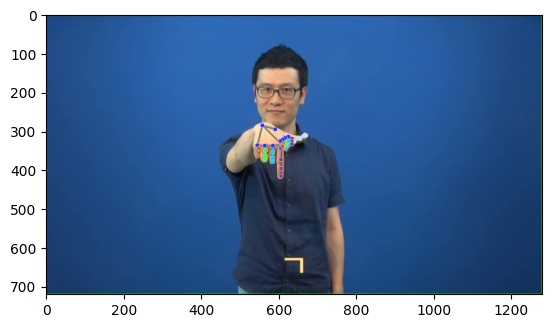

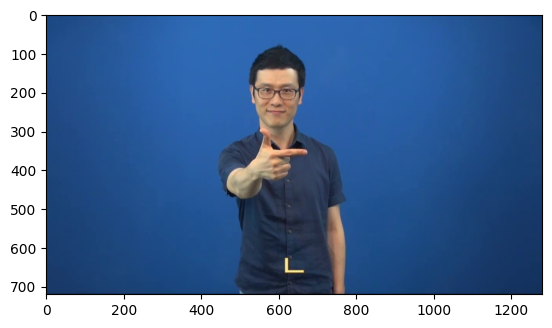

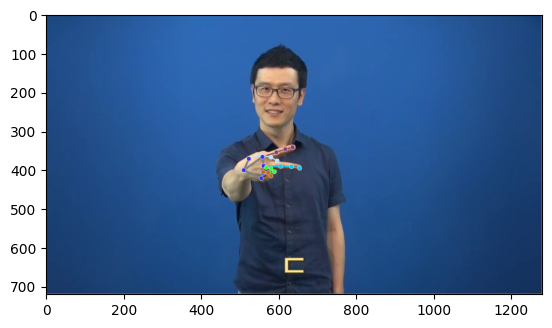

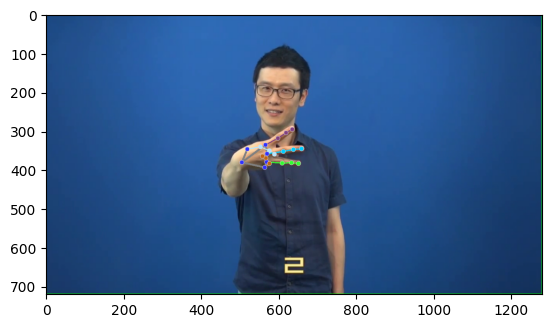

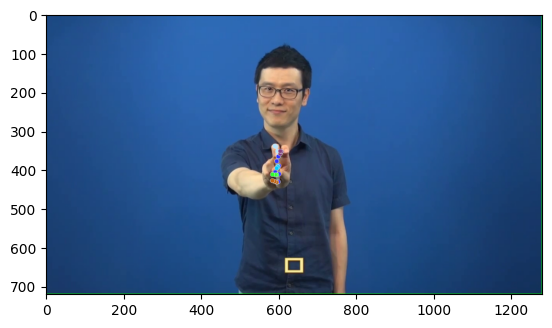

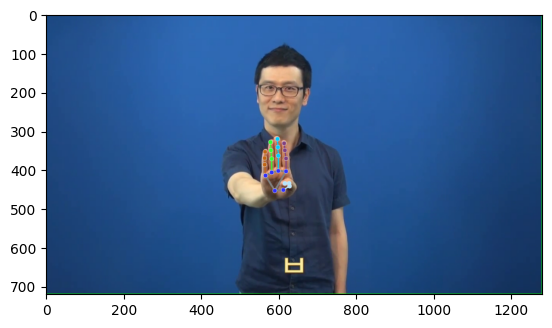

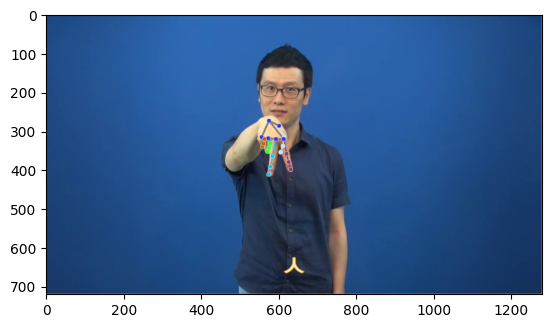

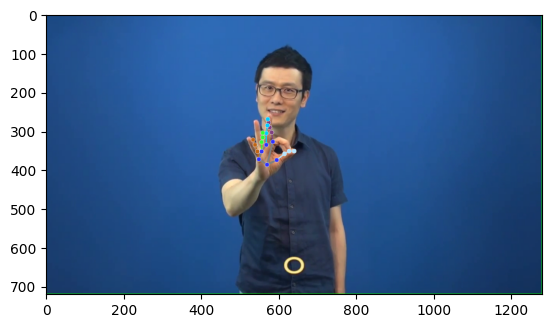

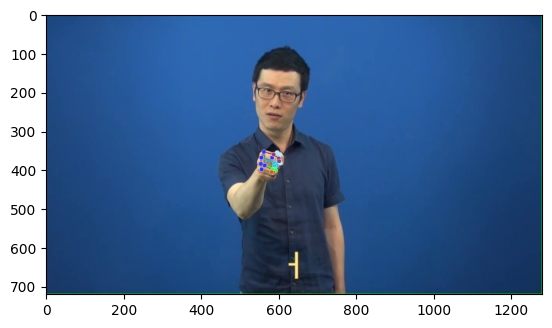

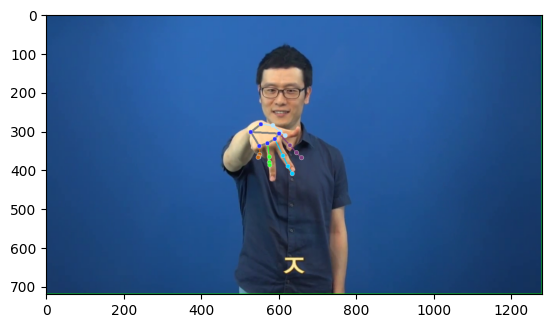

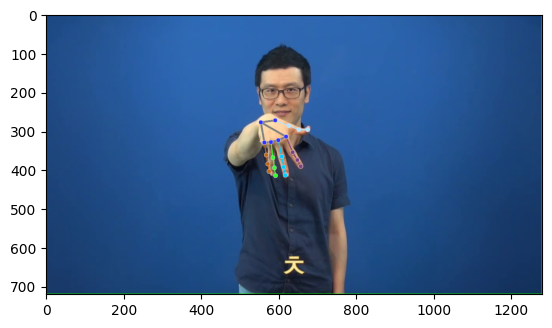

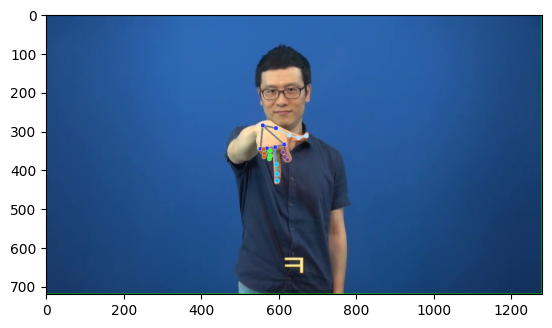

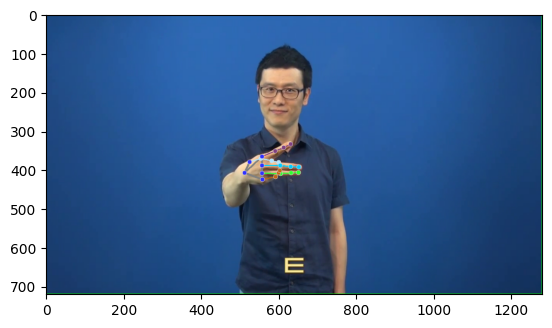

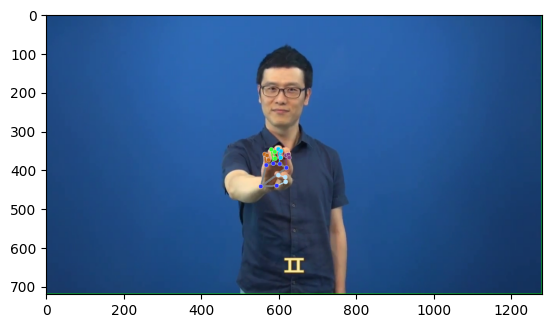

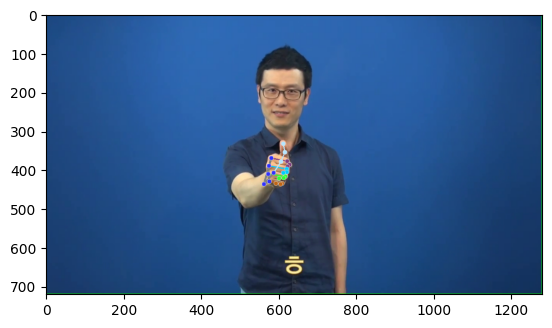

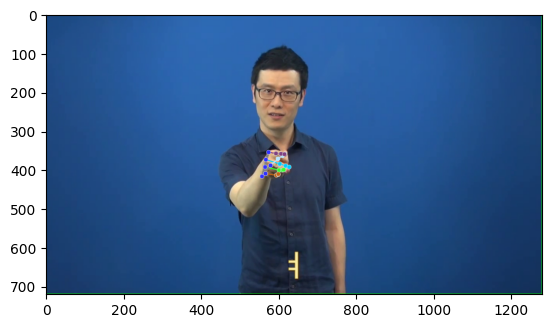

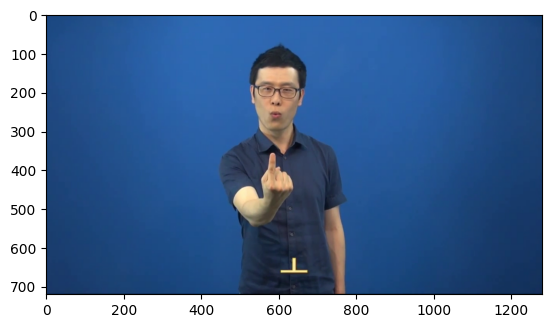

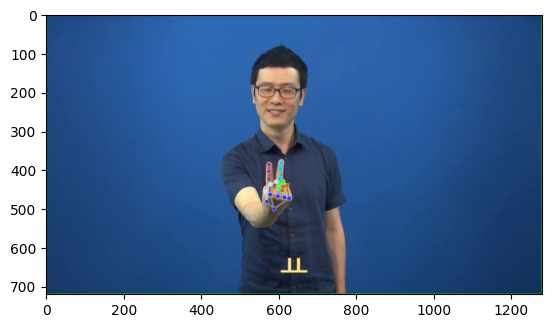

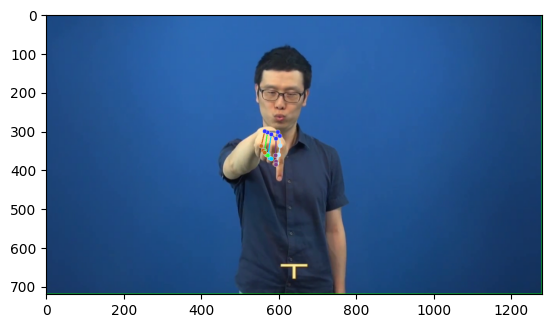

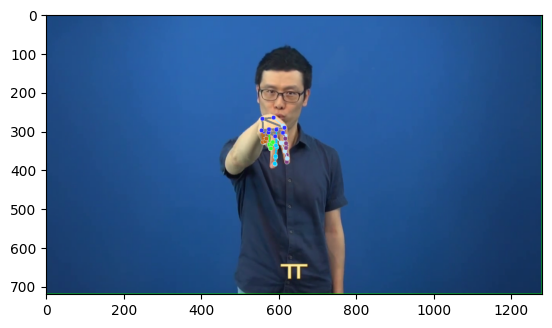

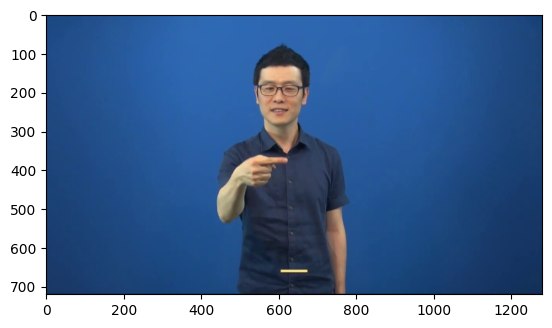

['1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '21', '22', '24', '25', '26', '27', '28', '29', '3', '30', '31', '32', '33', '34', '35', '4', '6', '7', '8']


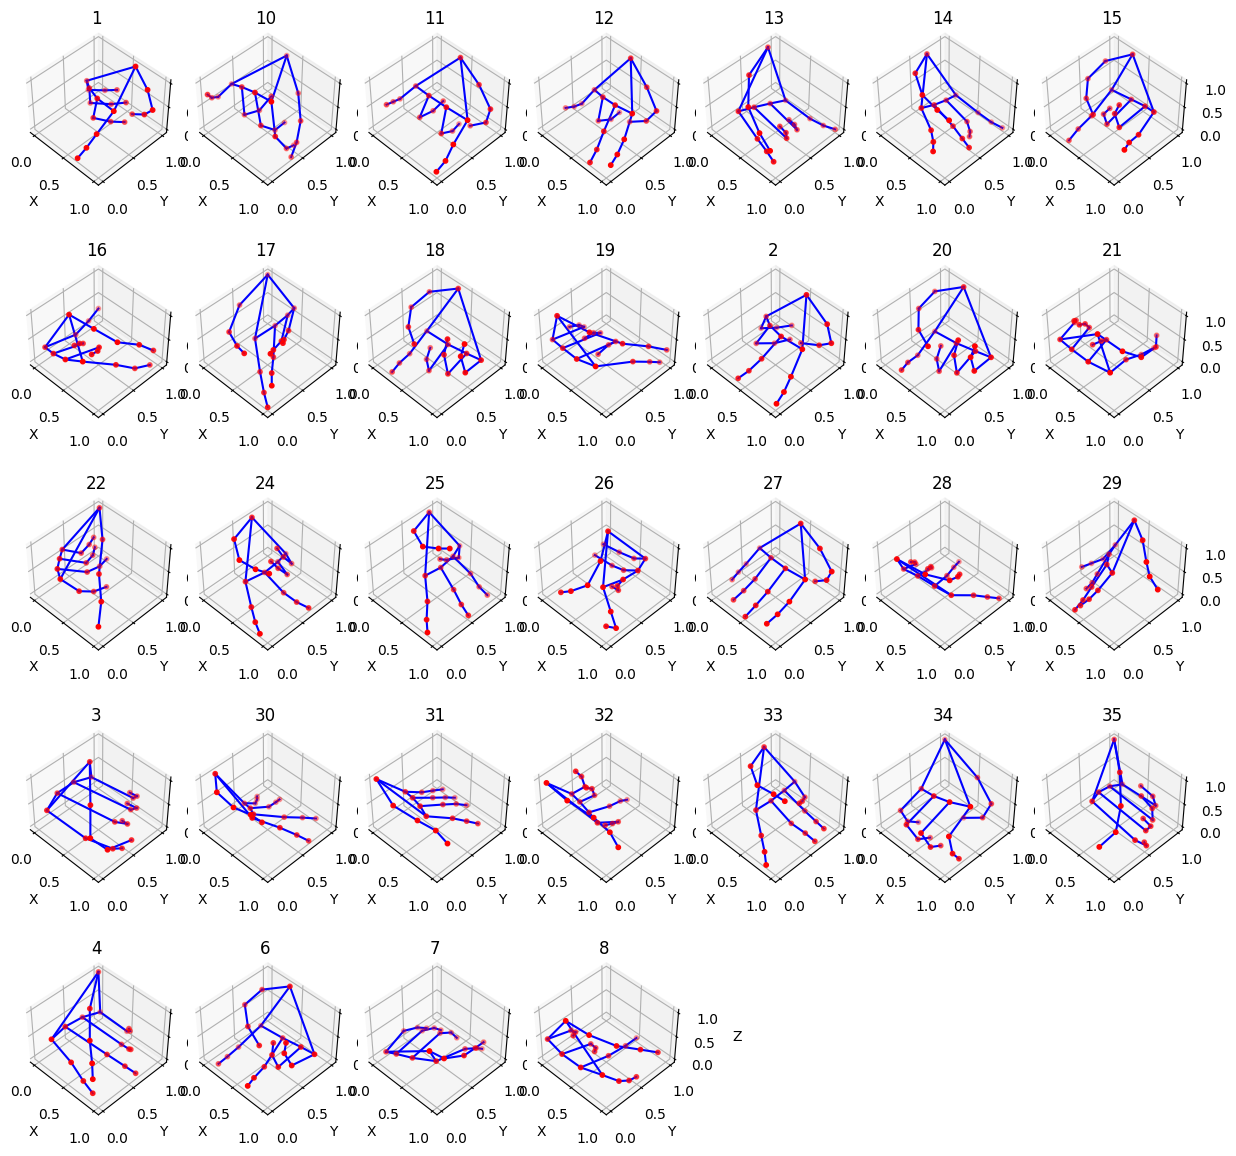

In [107]:
# plot_csv_landmarks('./dataset/korean/vowels_processed/csv/')
video_path = 'fingerspelling korean.mp4'
set_path = './dataset/korean/samples/vowels/'
processed_path = './dataset/korean/vowels_processed/'

# process_images(set_path, processed_path)
csv_dir = os.path.join(processed_path, 'csv')
plot_csv_landmarks(csv_dir)

image_num = 5
image_path = os.path.join(set_path, f'{image_num}.png')
# process_image_data(image_path, processed_path)


In [ ]:


process_images_in_directory(set_path, processed_path)
# plot_csv_landmarks('./dataset/korean/vowels_processed/csv/')